# Заработная плата в России
В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [1]:
import pandas as pd
salaries = pd.read_csv("WAG_C_M.csv",";", index_col=["month"], parse_dates=["month"], dayfirst=True)
salaries.columns = ["Salary"]
salaries.head()

FileNotFoundError: File b'WAG_C_M.csv' does not exist

Populating the interactive namespace from numpy and matplotlib


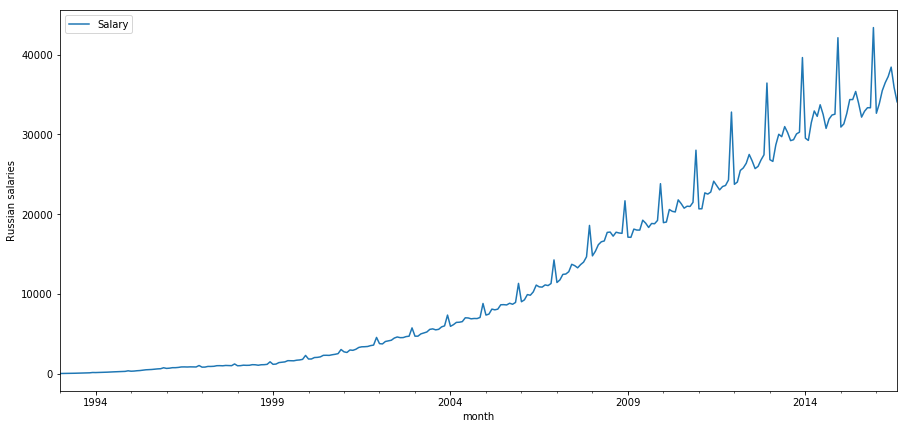

In [2]:
%pylab inline
pylab.figure(figsize(15,7))
salaries.plot()
pylab.ylabel("Russian salaries")
pylab.show()

## Преобразование данных
Визуально очень хорошо видно, что ряд не стационарен. Есть тренд, сезонность, дисперсия со временем увеличивается. Однако для более детального анализа построим STL декомпозицию и посчитаем критерий Дики-Фуллера

C:\Program Files\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Критерий Дики-Фуллера: p=0.9918


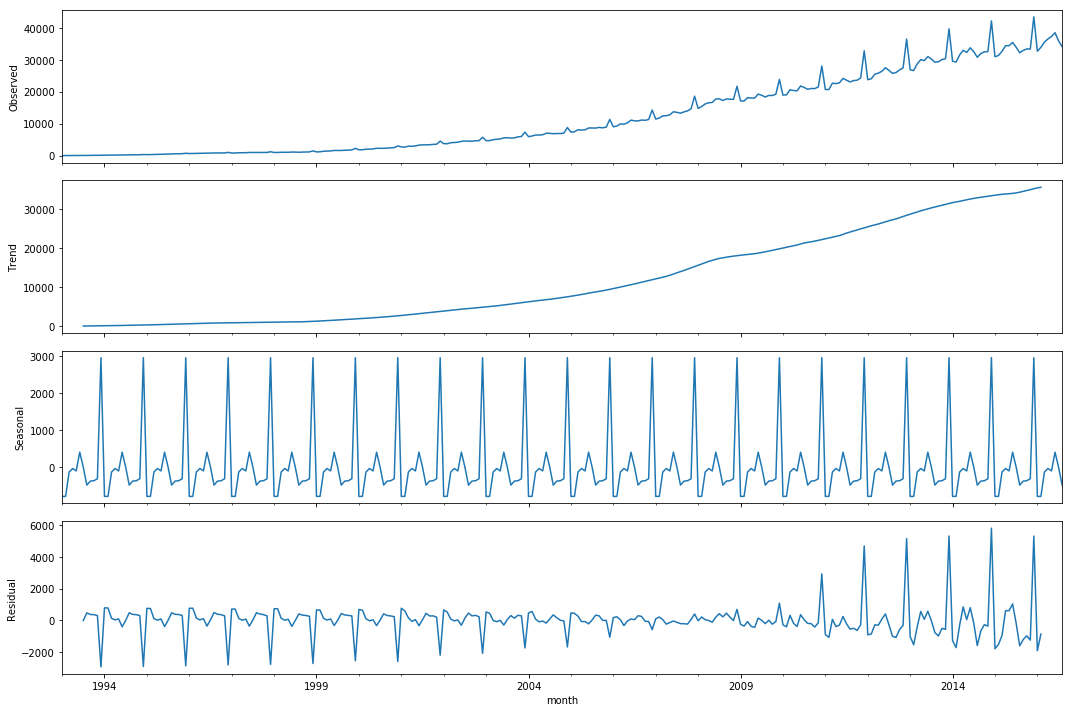

In [3]:
import statsmodels.api as sm
def stl_decompose_pvalue(series):
    (adf,pvalue,usedlag,nobes,icbest,resstore) = sm.tsa.stattools.adfuller(series)
    print("Критерий Дики-Фуллера: p=%.4f" % pvalue)
    pylab.figure(figsize(15,10))
    sm.tsa.seasonal_decompose(series).plot()
    pylab.show()
stl_decompose_pvalue(salaries["Salary"])

Критерий Дики-Фуллера и STL декомпозиция подтвердили наши предположения.
- Ряд нестационарен (критерий Дики-Фуллера не отвергает гипотезу нестационарности)
- Есть выраженные тренд и сезонность.
- Остатки меняют свое значение с преимущественно отрицательных на преимущественно положительные, их дисперсия значительно увеличивается.

### Преобразование Бокса-Кокса
Попробуем стабилизировать дисперсию с помощью преобразования Бокса-Кокса:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.6969


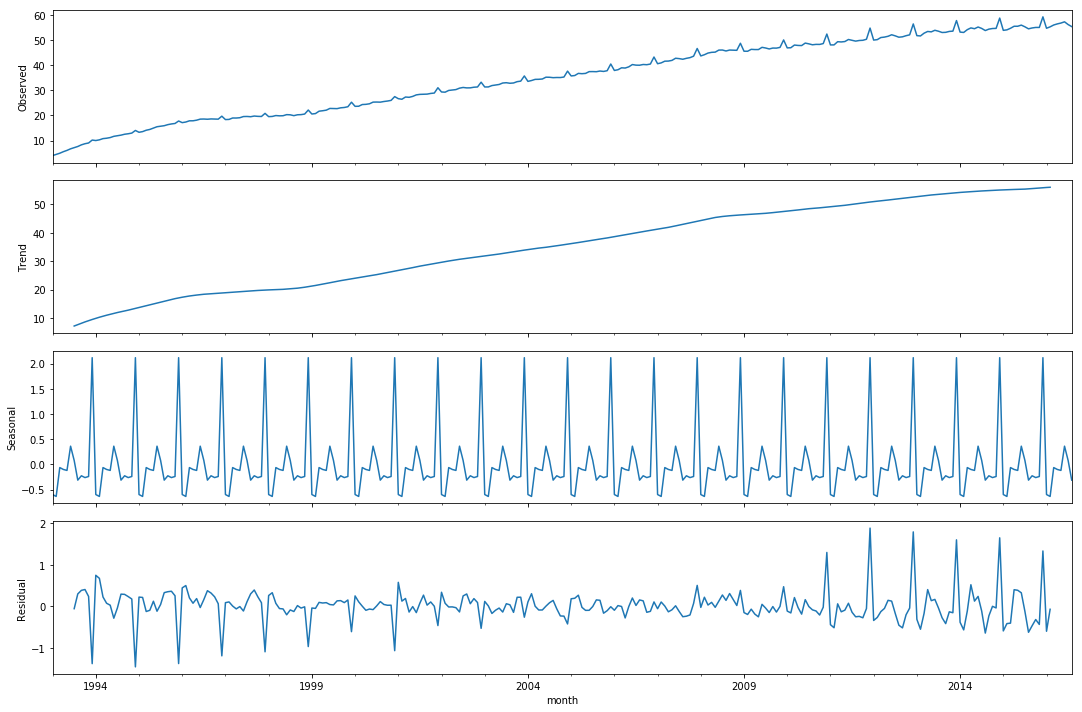

In [4]:
from scipy import stats
salaries["Salary_box"], lmbda = stats.boxcox(salaries["Salary"])
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
stl_decompose_pvalue(salaries["Salary_box"])

- Ряд остался нестационарным (критерий Дики-Фуллера не отвергает гипотезу нестационарности, хотя его значение уменьшилось).
- Сохранились тренд и сезонность.
- Остатки меняют свое значение с преимущественно отрицательных на преимущественно положительные. Дисперсия остатков несколько уменьшилась.

### Дифференцирование
Попытаемся сделать ряд стационарным с помощью сезонного дифференцирования; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.0147


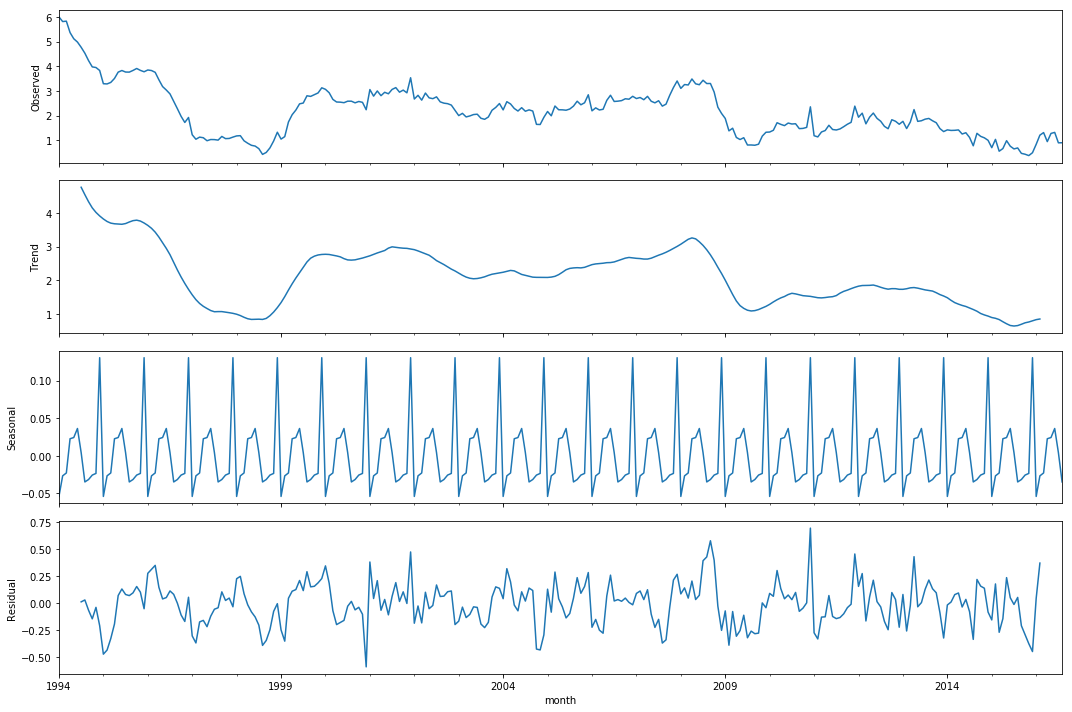

In [5]:
salaries["Salary_box_season"] = salaries["Salary_box"] - salaries["Salary_box"].shift(12)
stl_decompose_pvalue(salaries["Salary_box_season"].dropna())

- Ряд все ещё выглядит нестационарным, хотя критерий Дики-Фуллера уже отвергает гипотезу нестационарности.
- Сохранился тренд.
- Дисперсия остатков выровнялась.

Попробуем добавить обычное дифференцирование к сезонному и таким образом избавиться от тренда.

Критерий Дики-Фуллера: p=0.0000


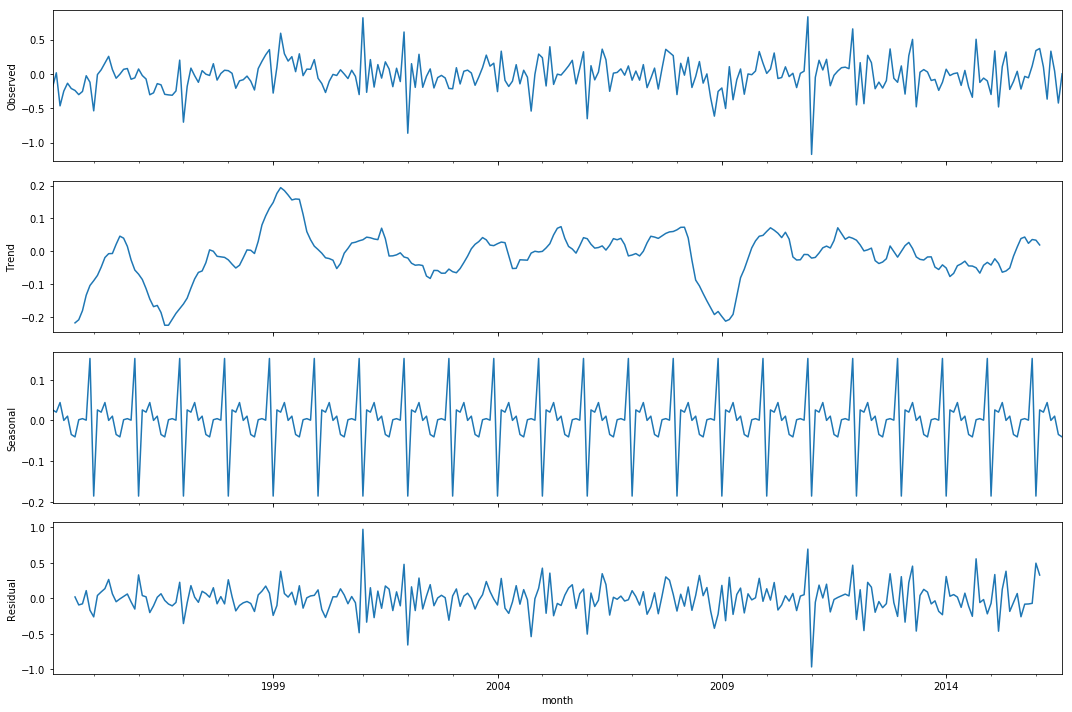

In [6]:
salaries["Salary_box_diff"] = salaries["Salary_box_season"] - salaries["Salary_box_season"].shift(1)
stl_decompose_pvalue(salaries["Salary_box_diff"].dropna())

- Ряд стал похож на стационарный. Критерий Дики-Фуллера также отвергает гипотезу нестационарности.
- Тренд исчез. Остались выбросы в начале выборки, в районе 1999 года и в районе 2009 года. Можно предположить, что это связано с кризисами.
- Дисперсия остатков похожа на белый шум.

## Подбор модели
Посмотрим на ACF и PACF полученного ряда:

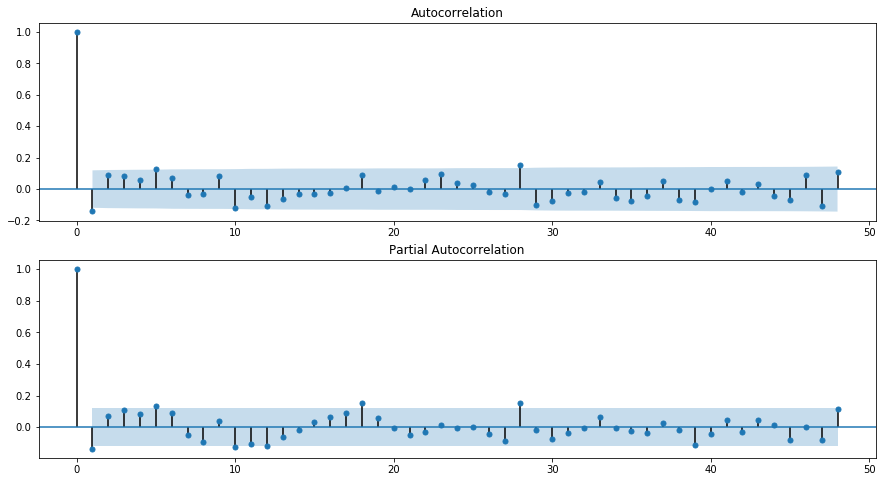

In [7]:
salaries_modified_values = salaries["Salary_box_diff"].dropna().values.squeeze()
pylab.figure(figsize(15,8))
ax = pylab.subplot(211)
sm.graphics.tsa.plot_acf(salaries_modified_values, lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salaries_modified_values, lags=48, ax=ax)
pylab.show()

##### По графикам ACF и PACF выберем начальные приближения для гиперпараметров:
- Q=0, - значимых сезонных лагов на ACF нет
- q=5, - на графике ACF имеется три значимых несезонных лага 1, 5 и 28. 28 - слишком большое значение, поэтому выбираем 5
- P=4, - на графике PACF значимым является 48 лаг. Он сезонный, соответственно 48/12 = 4
- p=5, - выбираем между 1, 5, 18 и 28 лагами. На мой взгляд оптимальное значение 5.

In [8]:
Qs = range(0, 1)
qs = range(0, 6)
Ps = range(0, 5)
ps = range(0, 6)
d=1
D=1
S=12

In [9]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

180

Подберем значения гиперпараметров полным перебором

In [10]:
%%time
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings("ignore")

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        pi,qi,Pi,Qi = param
        model=sm.tsa.statespace.SARIMAX(
            salaries["Salary_box"],
            order=(pi, d, qi),
            seasonal_order=(Pi, D, Qi, S)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print("wrong parameters:", param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings("default")

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 2, 0))
('wrong parameters:', (1, 2, 3, 0))
('wrong parameters:', (1, 2, 4, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 4, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 2, 0))
('wrong parameters:', (2, 2, 3, 0))
('wrong parameters:', (2, 2, 4, 0))
('wrong parameters:', (2, 3, 0, 0))
('wrong parameters:', (2, 3, 1, 0))
('wrong parameters:', (2, 3, 2, 0))
('wrong parameters:', (2, 3, 3, 0))
('wrong parameters:', (2, 3, 4, 0))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 2, 0))
('wrong parameters:', (3, 2, 3, 0))
('wrong parameters:', (3, 2, 4, 0))
('wrong parameters:', (3, 3, 0, 0))
('wrong parameters:', (3, 3,

Посмотрим пять лучших по AIC наборов параметров

In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ["parameters", "aic"]
print(result_table.sort_values(by = "aic", ascending=True).head(5))

       parameters        aic
110  (5, 5, 1, 0) -25.910444
111  (5, 5, 2, 0) -24.568315
109  (5, 5, 0, 0) -22.886793
112  (5, 5, 3, 0) -22.709343
113  (5, 5, 4, 0) -22.412133


Лучшая модель:

In [12]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                         Salary_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.955
Date:                            Wed, 16 Aug 2017   AIC                            -25.910
Time:                                    14:30:19   BIC                             17.877
Sample:                                01-01-1993   HQIC                            -8.355
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0197      5.001      0.004      0.997      -9.782       9.822
ar.L2          0.0086      3.383   

Остатки модели:

Критерий Стьюдента: p=0.609171
Критерий Дики-Фуллера: p=0.000000


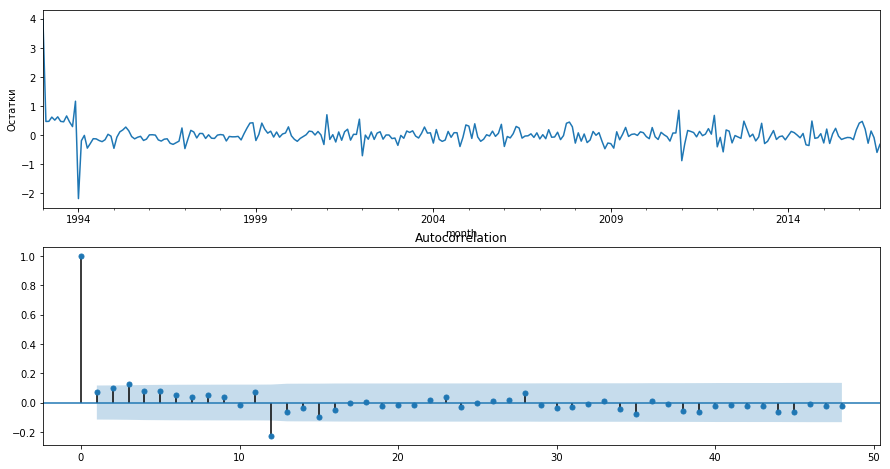

In [13]:
pylab.figure(figsize(15,8))
pylab.subplot(211)
best_model.resid.plot()
pylab.ylabel(u"Остатки")

ax = pylab.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Остатки
- несмещены (подтверждается критерием Стьюдента);
- стационарны (подтверждается критерием Дики-Фуллера и визуально);
- неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

Посмотрим, насколько хорошо модель описывает данные:

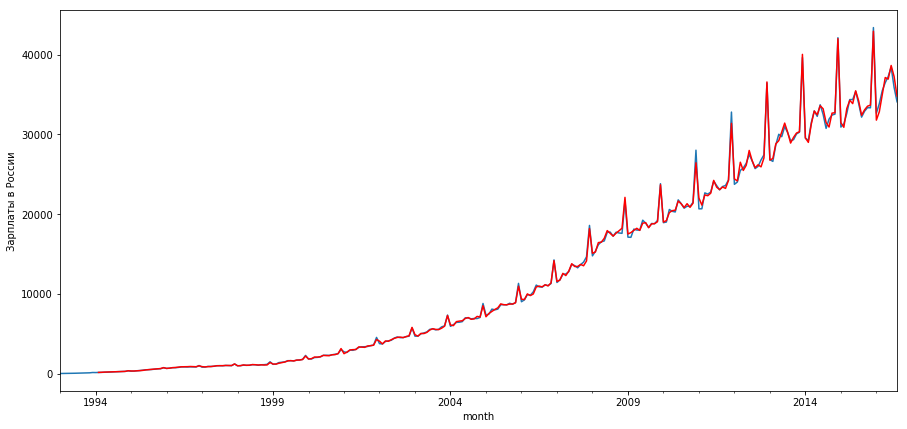

In [16]:
import numpy as np
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
salaries_model = pd.DataFrame(
    invboxcox(best_model.fittedvalues, lmbda),
    salaries["Salary_box_diff"].dropna().index,
    ["Salary"])
pylab.figure(figsize(15,7))
salaries["Salary"].plot()
salaries_model["Salary"].plot(color='r')
pylab.ylabel(u"Зарплаты в России")
pylab.show()

Как видно модель достаточно хорошо описывает данные. Модель уловила тренд, сезонность и даже увеличение дисперсии ошибки со временем.

## Прогноз

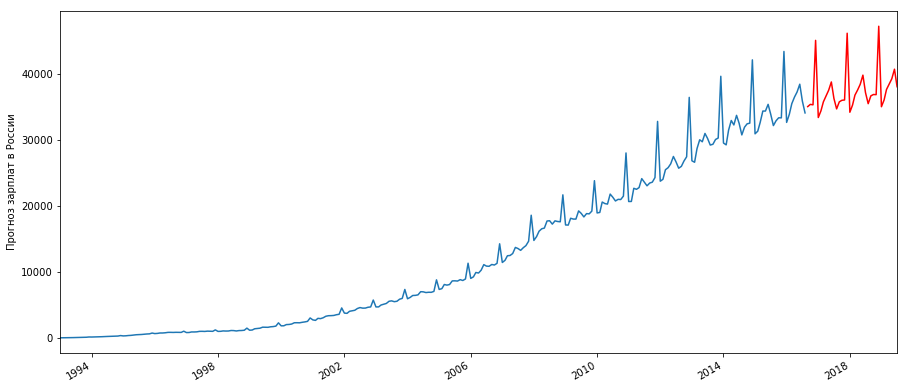

In [17]:
salaries_forecast = salaries[["Salary"]]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=salaries_forecast.columns)
salaries_forecast = pd.concat([salaries_forecast, future])
salaries_forecast["forecast"] = invboxcox(best_model.predict(start=284, end=284+36), lmbda)

pylab.figure(figsize(15,7))
salaries_forecast["Salary"].plot()
salaries_forecast["forecast"].plot(color='r')
pylab.ylabel(u"Прогноз зарплат в России")
pylab.show()

Прогноз также выглядит вполне адекватным, в нем также прослеживаются тренд, сезонность и увеличение дисперсии ошибки со временем.